## Модели прогнозирования объема убоя КРС по Республике Казахстан

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from IPython.display import display
import math
from prophet import Prophet
pd.set_option('display.max_columns', 130)


import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Подготовка данных и EDA

In [ ]:
df = pd.read_excel("Датасет по КРС.xlsx")
df.sample(5)

,Регион,Период,КРС,Осадки,Поголовье: КРС,Температура
1663,КОСТАНАЙСКАЯ ОБЛАСТЬ,2020-06,7744.80,23.1,531335.000,17.790000
2243,РЕСПУБЛИКА КАЗАХСТАН,2021-01,64084.35,NaN,7864722.000,NaN
388,АТЫРАУСКАЯ ОБЛАСТЬ,2017-05,1987.91,27.3,172171.000,19.177419
1056,ГОРОД АСТАНА,2023-01,NaN,27.3,377.375,-14.025806
1608,КОСТАНАЙСКАЯ ОБЛАСТЬ,2015-11,1655.05,31.8,420203.000,-5.566667


In [ ]:
df = df.drop(columns = ['Осадки','Температура'], axis = 'columns')
df

,Регион,Период,КРС,Поголовье: КРС
0,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-01,4455.35,372560.0
1,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-02,3654.20,399442.0
2,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-03,4287.08,425605.0
3,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-04,3923.21,440023.0
4,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-05,3849.70,444647.0
...,...,...,...,...
2485,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-08,9372.79,1120067.0
2486,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-09,15738.07,1101103.0
2487,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-10,10566.50,1078583.0
2488,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-11,11441.98,1056289.0


In [ ]:
df = df.rename(columns={'КРС': 'Объем убоя: КРС'})
df.sample(10)

,Регион,Период,Объем убоя: КРС,Поголовье: КРС
502,ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,2016-11,10903.98,918336.0
1914,МАНГИСТАУСКАЯ ОБЛАСТЬ,2021-05,58.40,29645.0
1229,ГШЫМКЕНТ,2024-04,523.12,NaN
1415,ЗАПАДНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,2019-10,3229.29,603672.0
1391,ЗАПАДНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,2017-10,3258.64,554724.0
2224,РЕСПУБЛИКА КАЗАХСТАН,2019-06,111206.18,8639306.0
375,АТЫРАУСКАЯ ОБЛАСТЬ,2016-04,1336.70,161022.0
1887,МАНГИСТАУСКАЯ ОБЛАСТЬ,2019-02,131.72,19932.0
834,ГАСТАНА,2024-07,1.70,NaN
1249,ЖАМБЫЛСКАЯ ОБЛАСТЬ,2015-12,9155.18,313339.0


In [ ]:
df['Период'] = pd.to_datetime(df['Период'], format='%Y-%m')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2490 entries, 0 to 2489
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Регион           2490 non-null   object        
 1   Период           2490 non-null   datetime64[ns]
 2   Объем убоя: КРС  2171 non-null   float64       
 3   Поголовье: КРС   2171 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 77.9+ KB


In [ ]:
df.isna().sum()

Регион               0
Период               0
Объем убоя: КРС    319
Поголовье: КРС     319
dtype: int64

In [ ]:
df = df.dropna().copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852 entries, 0 to 2489
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Регион           1852 non-null   object        
 1   Период           1852 non-null   datetime64[ns]
 2   Объем убоя: КРС  1852 non-null   float64       
 3   Поголовье: КРС   1852 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 72.3+ KB


In [ ]:
df

,Регион,Период,Объем убоя: КРС,Поголовье: КРС
0,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-01-01,4455.35,372560.0
1,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-02-01,3654.20,399442.0
2,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-03-01,4287.08,425605.0
3,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-04-01,3923.21,440023.0
4,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-05-01,3849.70,444647.0
...,...,...,...,...
2485,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-08-01,9372.79,1120067.0
2486,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-09-01,15738.07,1101103.0
2487,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-10-01,10566.50,1078583.0
2488,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-11-01,11441.98,1056289.0


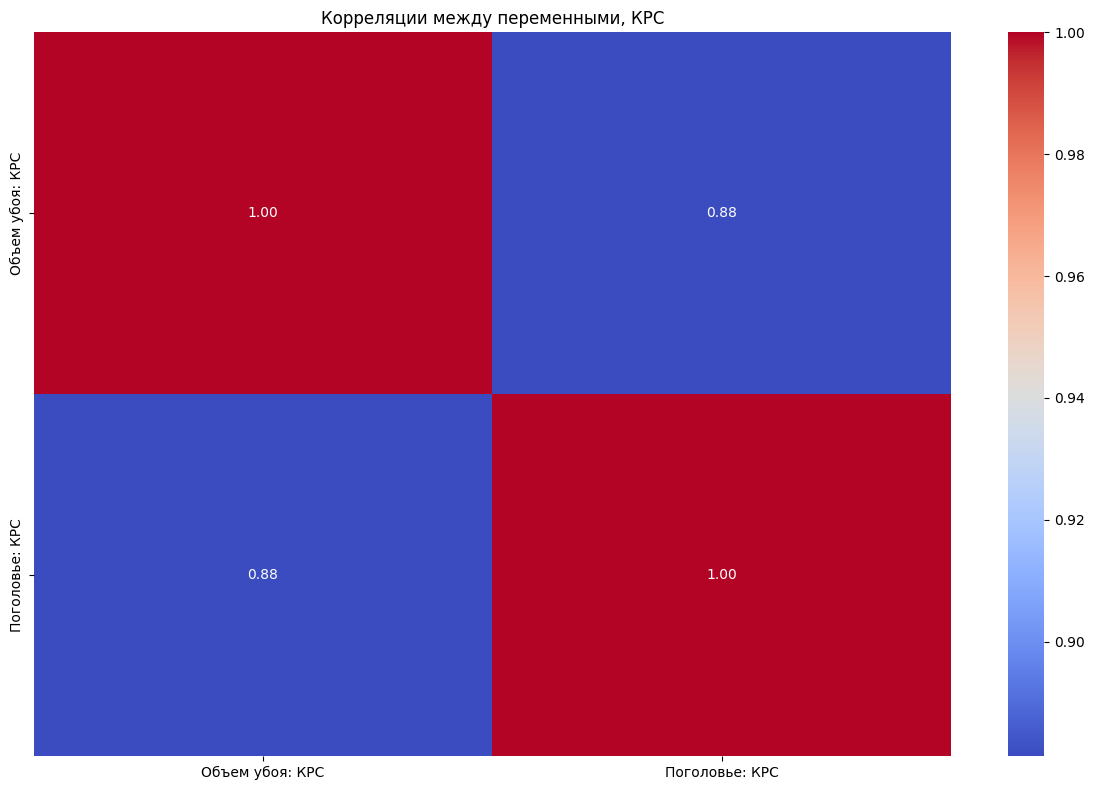

In [38]:
df_corr = df[[col for col in df.columns if col not in ["Период", 'Регион']]]

# 1. Correlation matrix
corr_matrix = df_corr.corr()

# 2. Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции между переменными, КРС")
plt.tight_layout()
plt.show()

In [195]:
# Set your target variable
target_var = "Объем убоя: КРС"

# Get correlations with the target variable
target_corr = corr_matrix[target_var].drop(target_var)  # exclude self-correlation

# Keep only features with |correlation| >= 0.5
selected_vars = target_corr[abs(target_corr) >= 0.5].index.tolist()

print("✅ Отобранные переменные с корреляцией >= 0.5:")
print(selected_vars)

# Optionally: create new dataframe with selected variables + target
df_selected = df_akmola_lagged[['Период'] + selected_vars + [target_var]]


✅ Отобранные переменные с корреляцией >= 0.5:
['КРС_t-1', 'Температура', 'Температура_t-1', 'Температура_t-2', 'Температура_t-3']


In [196]:
df_selected

,Период,КРС_t-1,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Объем убоя: КРС
4,2015-05-01,3923.21,14.574194,4.490000,-5.870968,-10.192857,3849.70
5,2015-06-01,3849.70,20.763333,14.574194,4.490000,-5.870968,4074.13
6,2015-07-01,4074.13,19.180645,20.763333,14.574194,4.490000,2221.96
7,2015-08-01,2221.96,16.529032,19.180645,20.763333,14.574194,2151.76
8,2015-09-01,2151.76,11.496667,16.529032,19.180645,20.763333,2728.61
...,...,...,...,...,...,...,...
115,2024-08-01,2029.47,17.338710,20.270968,21.043333,10.696774,2412.70
116,2024-09-01,2412.70,11.300000,17.338710,20.270968,21.043333,2909.66
117,2024-10-01,2909.66,3.832258,11.300000,17.338710,20.270968,2608.27
118,2024-11-01,2608.27,-4.343333,3.832258,11.300000,17.338710,3649.19


In [197]:
df_vif = df_selected[[col for col in df_selected.columns if col not in ["Период"]]]

X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Объем убоя: КРС"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data

,Variable,VIF
0,const,39.665178
1,КРС_t-1,2.141944
2,Температура,12.516309
3,Температура_t-1,18.995033
4,Температура_t-2,18.852870
5,Температура_t-3,12.842264


In [198]:
df_vif = df_selected[[col for col in df_selected.columns if col not in ["Период", 'Температура_t-2', 'Температура_t-3']]]

X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Объем убоя: КРС"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data

,Variable,VIF
0,const,33.223820
1,КРС_t-1,1.904064
2,Температура,4.561451
3,Температура_t-1,6.090972


In [199]:
df_selected = df_selected[['Период','КРС_t-1', 'Температура', 'Температура_t-1', 'Объем убоя: КРС']]
df_selected

,Период,КРС_t-1,Температура,Температура_t-1,Объем убоя: КРС
4,2015-05-01,3923.21,14.574194,4.490000,3849.70
5,2015-06-01,3849.70,20.763333,14.574194,4074.13
6,2015-07-01,4074.13,19.180645,20.763333,2221.96
7,2015-08-01,2221.96,16.529032,19.180645,2151.76
8,2015-09-01,2151.76,11.496667,16.529032,2728.61
...,...,...,...,...,...
115,2024-08-01,2029.47,17.338710,20.270968,2412.70
116,2024-09-01,2412.70,11.300000,17.338710,2909.66
117,2024-10-01,2909.66,3.832258,11.300000,2608.27
118,2024-11-01,2608.27,-4.343333,3.832258,3649.19


### Models

#### Многофакторная регрессия

In [200]:
def forward_selection(data, target, candidate_features, criterion="adj_r2"):
    remaining = list(candidate_features)
    selected = []
    best_score = -float("inf")
    best_model = None

    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            features = selected + [candidate]
            X = sm.add_constant(data[features])
            y = data[target]
            model = sm.OLS(y, X).fit()

            if criterion == "adj_r2":
                score = model.rsquared_adj
            elif criterion == "aic":
                score = -model.aic  # negative for maximizing
            else:
                raise ValueError("criterion must be 'adj_r2' or 'aic'")

            scores_with_candidates.append((score, candidate, model))

        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate, model = scores_with_candidates[0]

        if best_new_score > best_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            best_score = best_new_score
            best_model = model
            print(f"✅ Added: {best_candidate}, {criterion.upper()}: {best_score:.4f}")
        else:
            print("⛔ No improvement. Stopping.")
            break

    return selected, best_model


In [201]:
# Define target and candidate predictors
target = "Объем убоя: КРС"
candidate_features = df_selected.drop(columns=['Период', 'Объем убоя: КРС'])

# Drop rows with missing values
df_mlr = df_selected

# Run forward selection
selected_features, final_model = forward_selection(df_mlr, target, candidate_features, criterion="adj_r2")

# Show final summary

print(selected_features)
print("\n🧾 Final Model Summary:")
print(final_model.summary())



✅ Added: Температура_t-1, ADJ_R2: 0.4866
✅ Added: КРС_t-1, ADJ_R2: 0.5079
⛔ No improvement. Stopping.
['Температура_t-1', 'КРС_t-1']

🧾 Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:        Объем убоя: КРС   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     60.35
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           1.48e-18
Time:                        12:09:00   Log-Likelihood:                -913.04
No. Observations:                 116   AIC:                             1832.
Df Residuals:                     113   BIC:                             1840.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t     

In [203]:
df_selected

,Период,КРС_t-1,Температура,Температура_t-1,Объем убоя: КРС
4,2015-05-01,3923.21,14.574194,4.490000,3849.70
5,2015-06-01,3849.70,20.763333,14.574194,4074.13
6,2015-07-01,4074.13,19.180645,20.763333,2221.96
7,2015-08-01,2221.96,16.529032,19.180645,2151.76
8,2015-09-01,2151.76,11.496667,16.529032,2728.61
...,...,...,...,...,...
115,2024-08-01,2029.47,17.338710,20.270968,2412.70
116,2024-09-01,2412.70,11.300000,17.338710,2909.66
117,2024-10-01,2909.66,3.832258,11.300000,2608.27
118,2024-11-01,2608.27,-4.343333,3.832258,3649.19


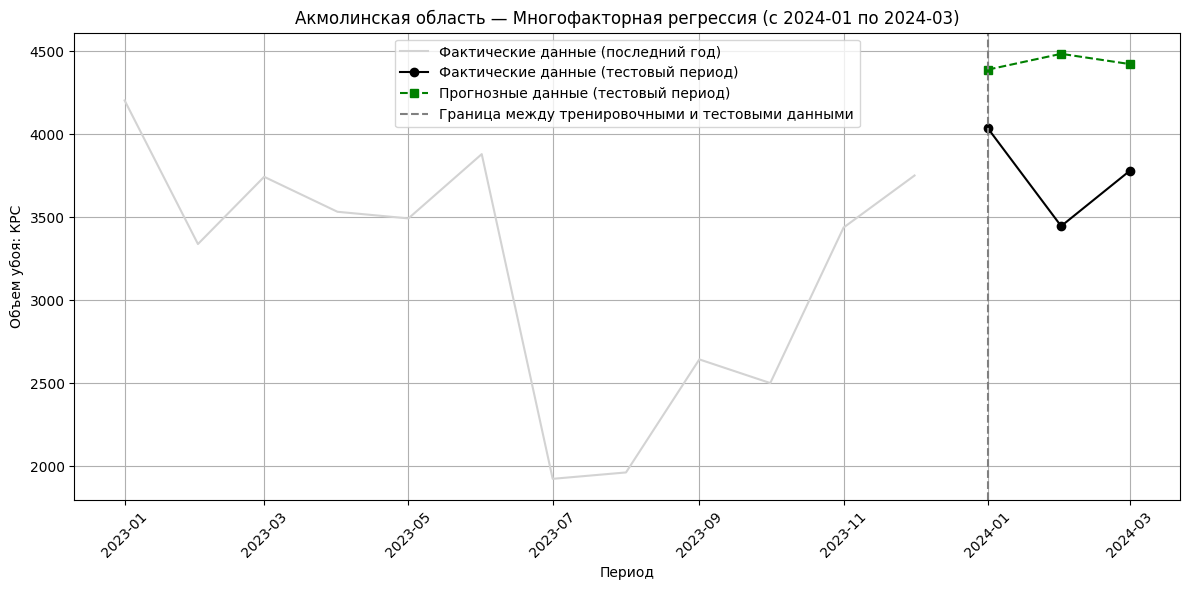

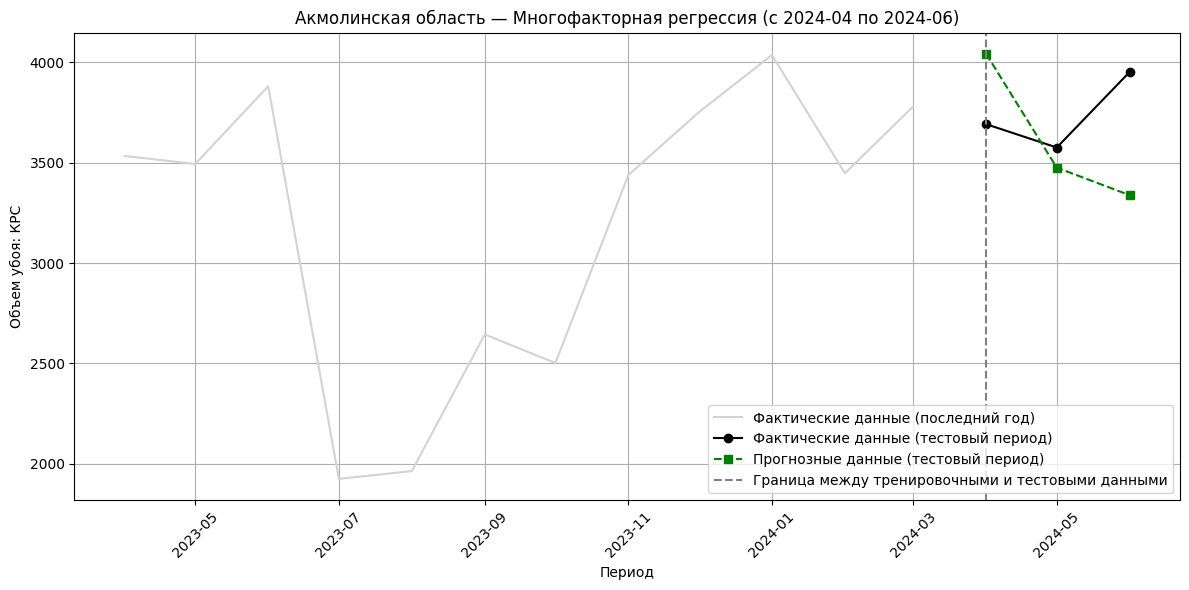

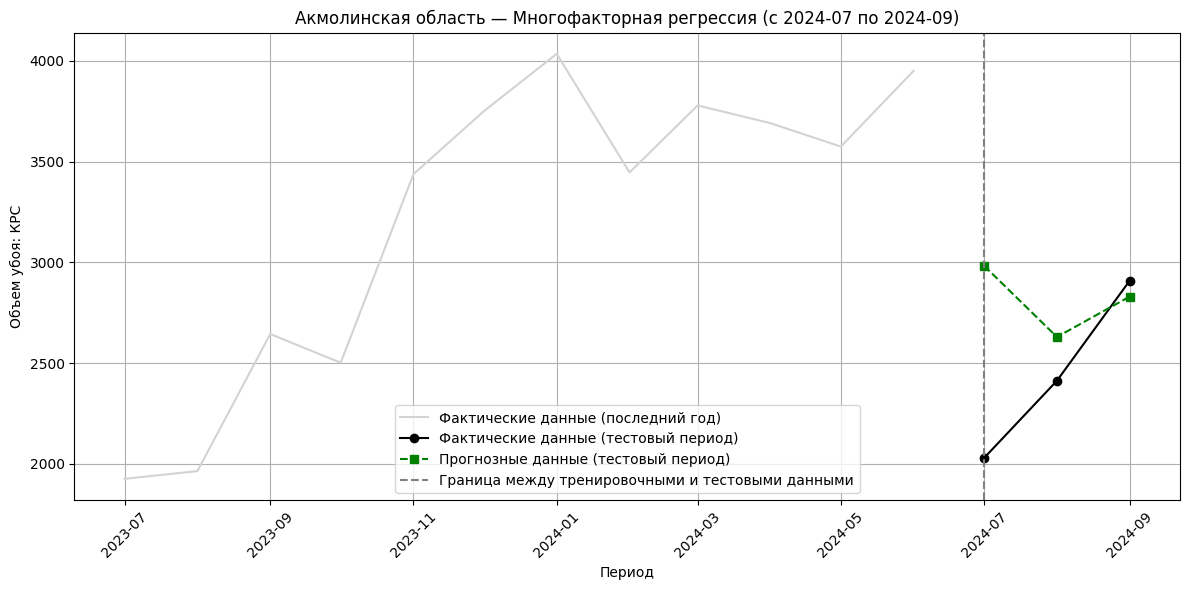

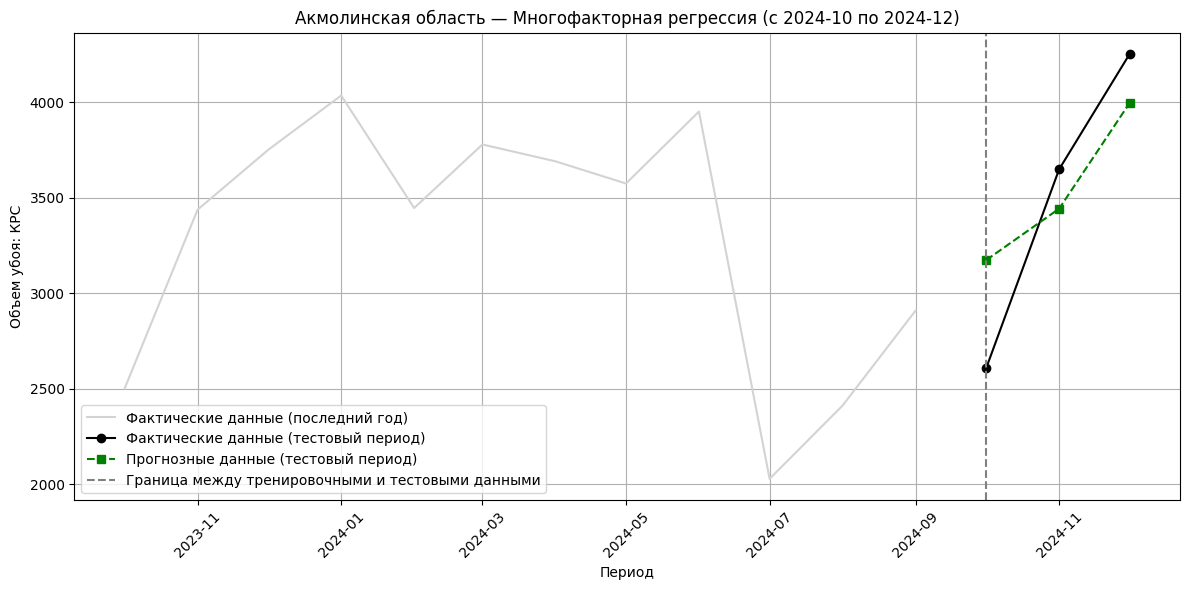

In [205]:
# Ensure your dataframe is sorted by time
df = df_selected.sort_values("Период").copy()

# # Selected features
# selected_features = [
#     'Температура_t-1', 'Поголовье: КРС', 'Температура_t-3', 'КРС_t-4', 'КРС_t-2', 'Осадки_t-1', 'Осадки_t-3', 'Поголовье: КРС_t-1'
# ]

target = "Объем убоя: КРС"
results = []

# Define 4 rolling test sets for 2024
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    # Drop NAs and align predictors
    X_train = sm.add_constant(train_df[selected_features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[selected_features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    # print(y_test, '\n', y_pred, '\n', y_test-y_pred)

    r2 = r2_score(y_test, y_pred)
    # print("Zero values in y_test:", (y_test == 0).sum())


    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Многофакторная регрессия (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [207]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period        RMSE         MAE   MAPE (%)        R²
0  2024-01 to 2024-03  733.161962  677.454099  18.610954 -8.250161
1  2024-04 to 2024-06  412.175571  354.808744   9.276756 -5.854117
2  2024-07 to 2024-09  566.469534  416.593867  19.567821 -1.471390
3  2024-10 to 2024-12  377.731487  342.679731  11.119356  0.691006
4             Average  522.384639  447.884110  14.643722 -3.721165


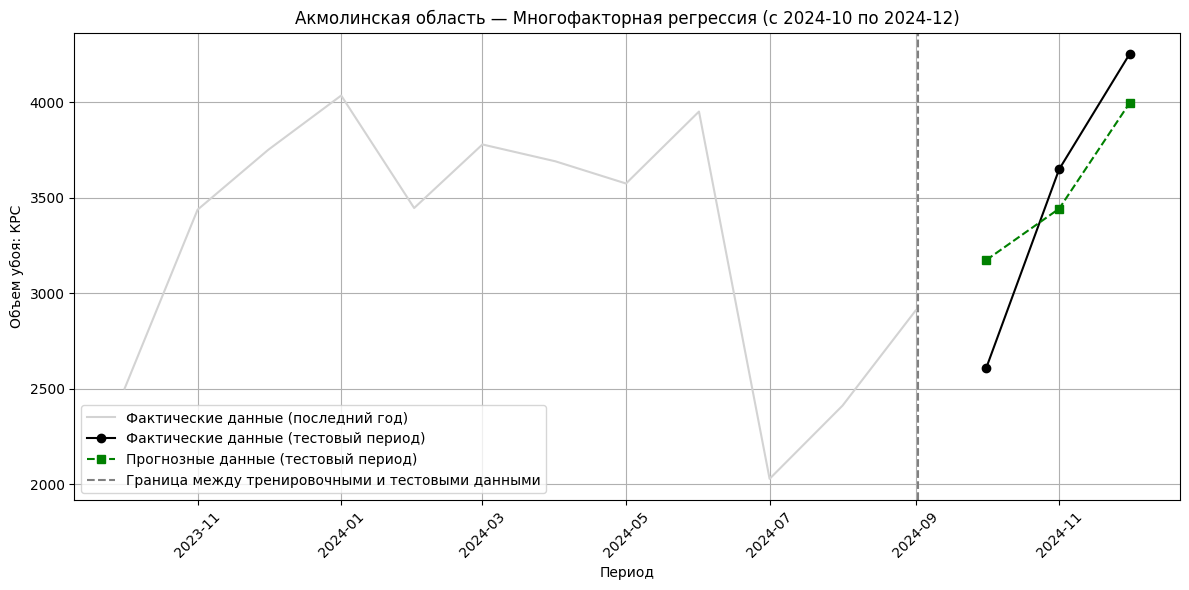

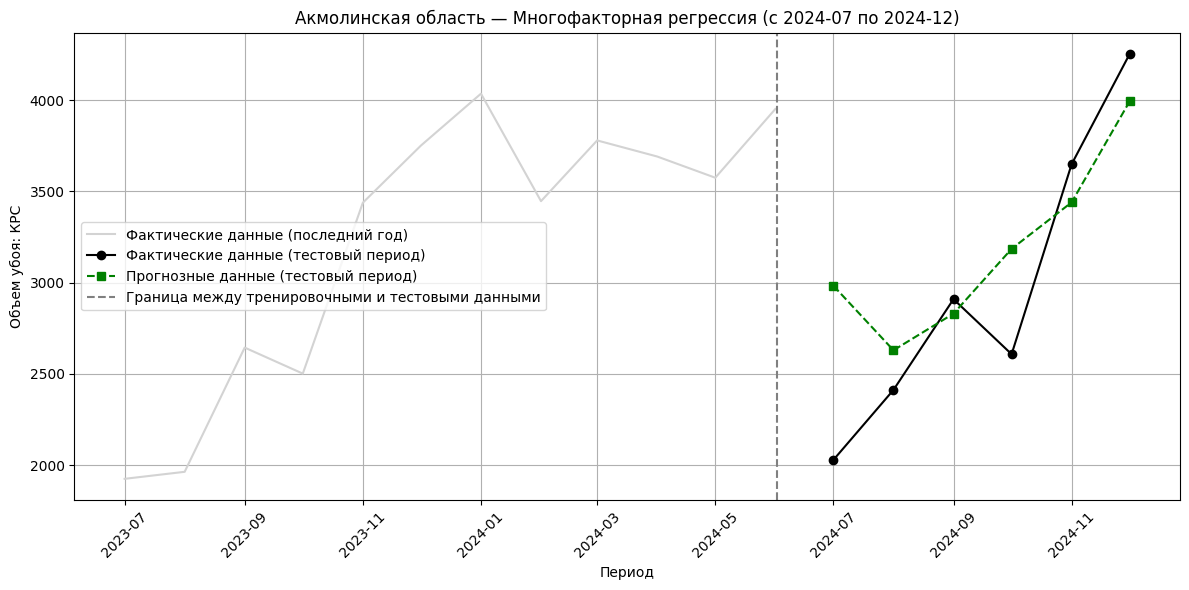

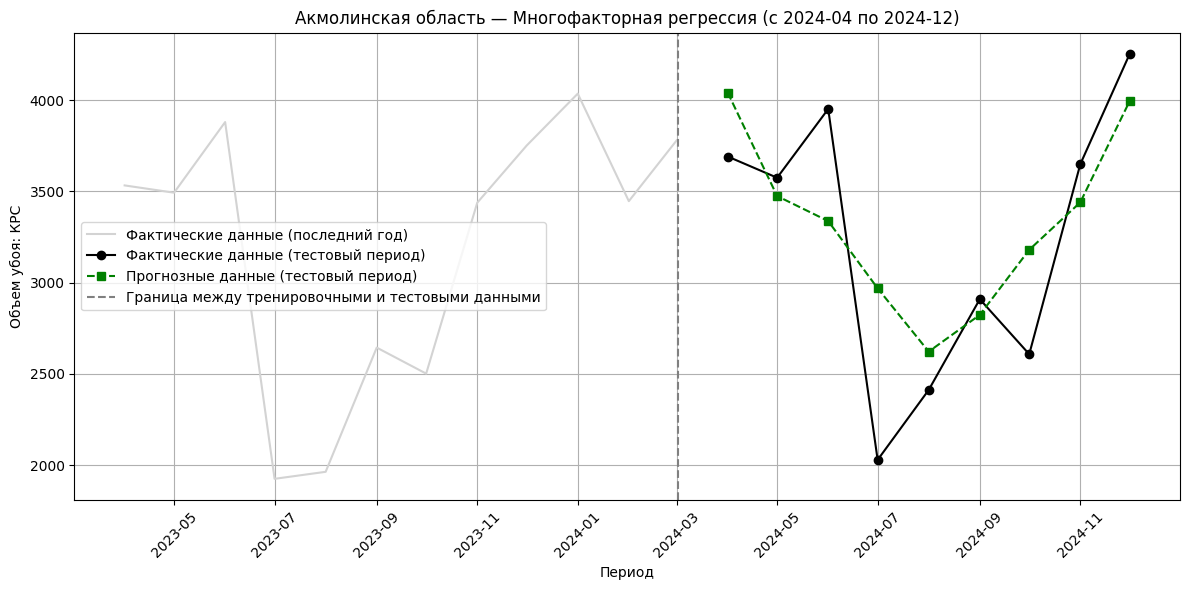

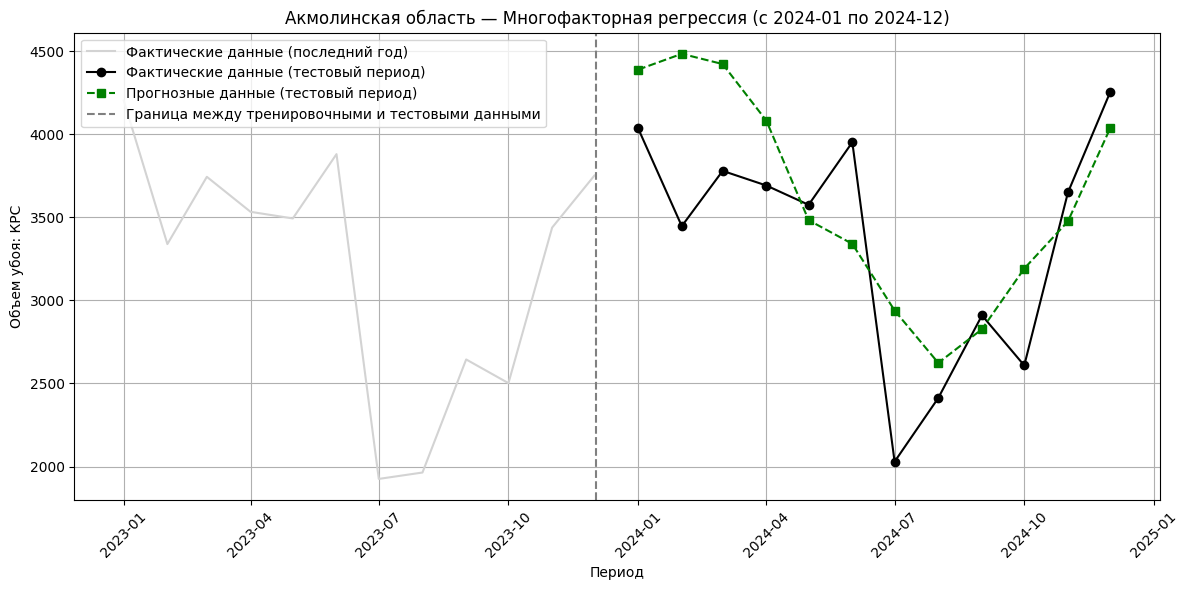

In [208]:
# Ensure your dataframe is sorted by time
df = df_selected.sort_values("Период").copy()

# # Selected features
# selected_features = [
#     'Температура_t-1', 'Поголовье: КРС', 'Температура_t-3', 'КРС_t-4', 'КРС_t-2', 'Осадки_t-1', 'Осадки_t-3', 'Поголовье: КРС_t-1'
# ]

target = "Объем убоя: КРС"
results = []

# Define 4 rolling test sets for 2024
horizons = [3, 6, 9, 12]

for horizon in horizons:

    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    # Drop NAs and align predictors
    X_train = sm.add_constant(train_df[selected_features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[selected_features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    # print(y_test, '\n', y_pred, '\n', y_test-y_pred)

    r2 = r2_score(y_test, y_pred)
    # print("Zero values in y_test:", (y_test == 0).sum())


    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Многофакторная регрессия (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [210]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period        RMSE         MAE   MAPE (%)        R²
0  2024-10 to 2024-12  377.731487  342.679731  11.119356  0.691006
1  2024-07 to 2024-12  484.184879  382.540248  15.442225  0.590892
2  2024-04 to 2024-12  457.208682  370.967903  13.277862  0.597465
3  2024-01 to 2024-12  535.658803  441.985402  14.424716  0.369678
4             Average  463.695963  384.543321  13.566040  0.562260


#### SARIMA (auto-arima)

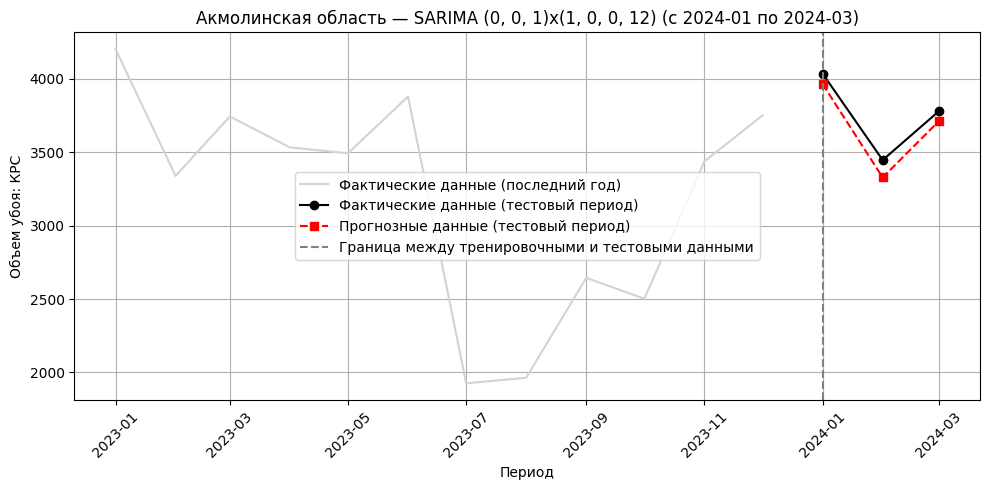

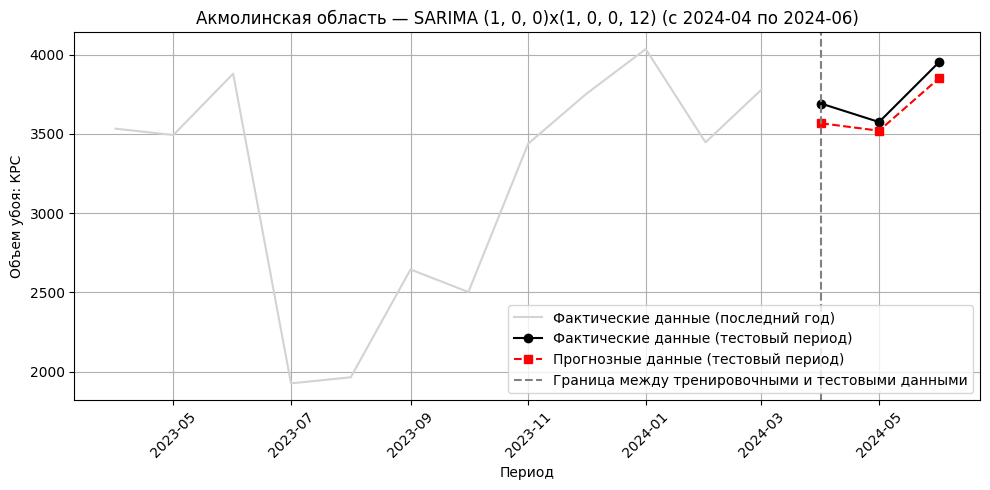

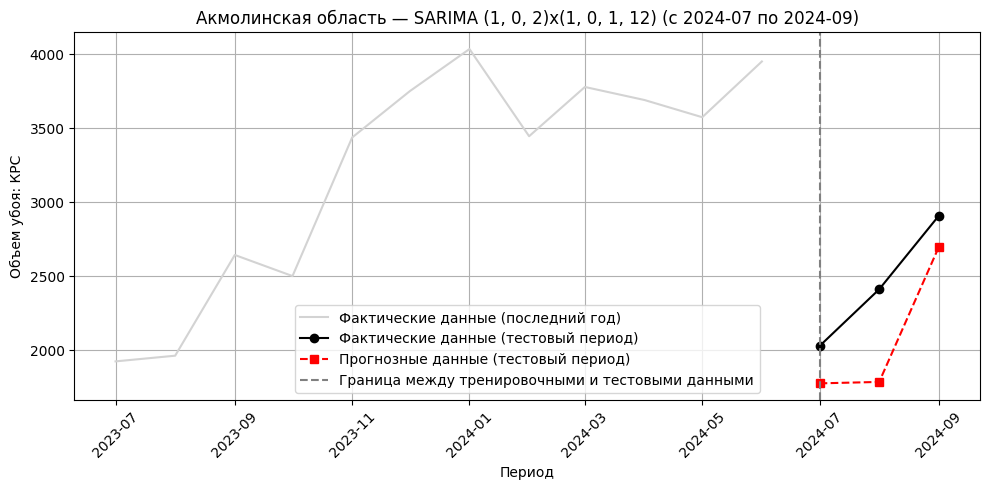

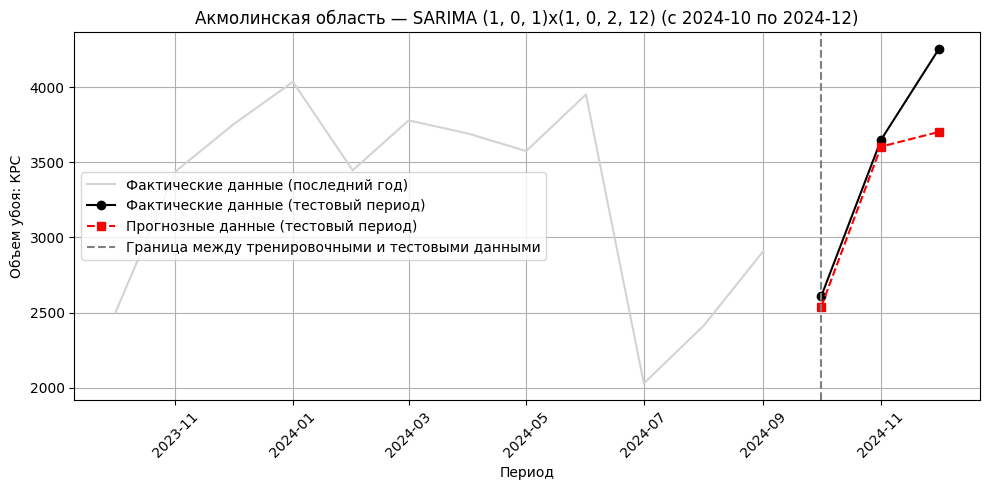

In [211]:
df = df_selected.sort_values("Период").copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

# Определим 4 тестовых периода на 3 месяца
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Разделим данные
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=3)
        forecast = pd.Series(forecast).reset_index(drop=True)
        # forecast = pd.Series(model.predict(n_periods=len(y_test)), index=y_test.index)
        # print(y_test, '\n', forecast, '\n', y_test-forecast)
        # print("Are indices equal?", y_test.index.equals(forecast.index))



        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMA {model.order}x{model.seasonal_order} (с {test_start.strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        # print("Zero values in y_test:", (y_test == 0).sum())


    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [212]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period        RMSE         MAE   MAPE (%) SARIMA order  \
0  2024-01 to 2024-03   88.749815   85.677578   2.328141    (0, 0, 1)   
1  2024-04 to 2024-06   97.800857   93.478571   2.488361    (1, 0, 0)   
2  2024-07 to 2024-09  408.058718  362.854964  15.200539    (1, 0, 2)   
3  2024-10 to 2024-12  321.795357  221.584603   5.606952    (1, 0, 1)   
4             Average  229.101187  190.898929   6.405999          NaN   

  Seasonal order  
0  (1, 0, 0, 12)  
1  (1, 0, 0, 12)  
2  (1, 0, 1, 12)  
3  (1, 0, 2, 12)  
4            NaN  


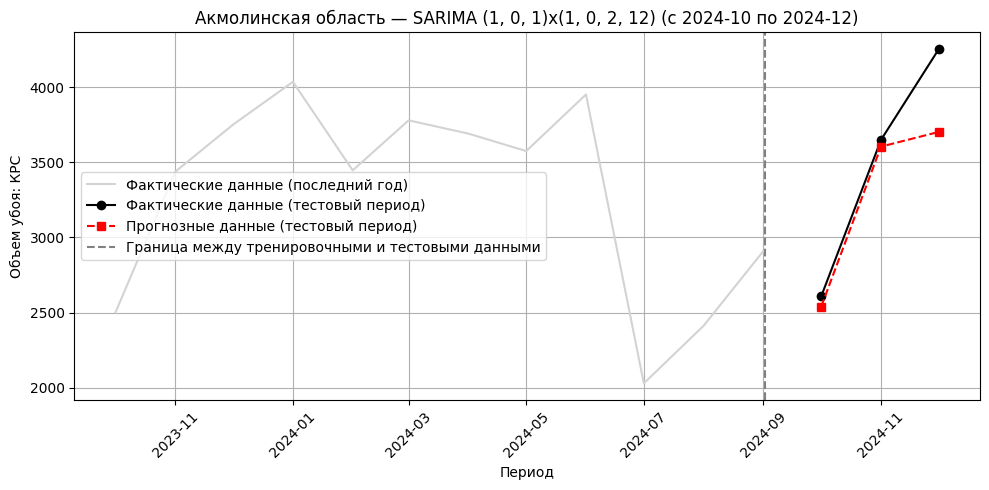

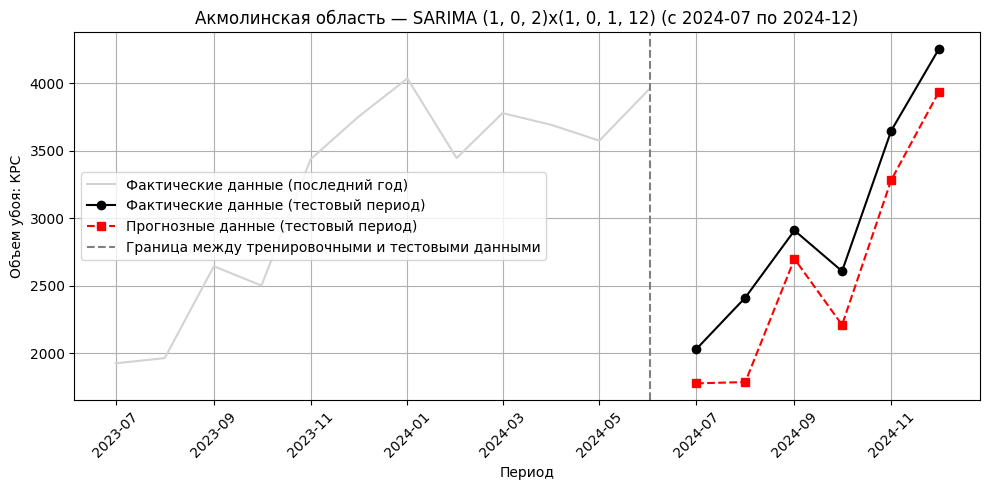

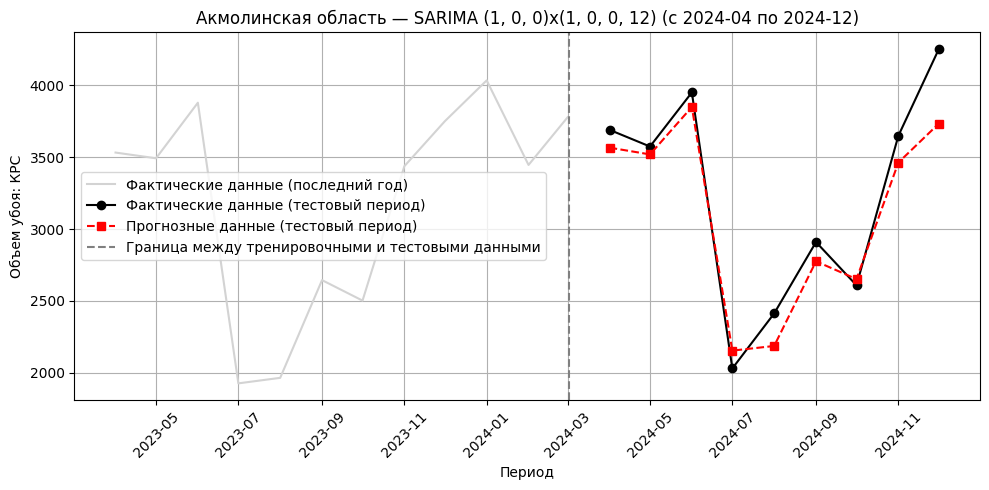

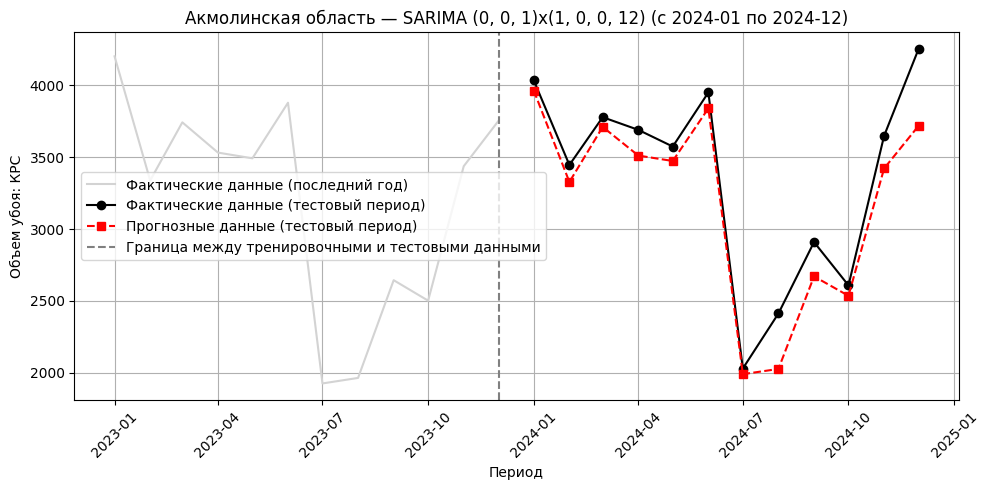

In [213]:
df = df_selected.sort_values("Период").copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:
    # test_start = pd.to_datetime(start)
    # test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)
    # Разделим данные
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=horizon)
        forecast = pd.Series(forecast).reset_index(drop=True)
        # forecast = pd.Series(model.predict(n_periods=len(y_test)), index=y_test.index)
        # print(y_test, '\n', forecast, '\n', y_test-forecast)
        # print("Are indices equal?", y_test.index.equals(forecast.index))



        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMA {model.order}x{model.seasonal_order} (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        # print("Zero values in y_test:", (y_test == 0).sum())


    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [214]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period        RMSE         MAE   MAPE (%) SARIMA order  \
0  2024-10 to 2024-12  321.795357  221.584603   5.606952    (1, 0, 1)   
1  2024-07 to 2024-12  385.778768  361.740736  13.060998    (1, 0, 2)   
2  2024-04 to 2024-12  215.890164  168.244188   5.173660    (1, 0, 0)   
3  2024-01 to 2024-12  228.841528  178.798746   5.430077    (0, 0, 1)   
4             Average  288.076454  232.592068   7.317922          NaN   

  Seasonal order  
0  (1, 0, 2, 12)  
1  (1, 0, 1, 12)  
2  (1, 0, 0, 12)  
3  (1, 0, 0, 12)  
4            NaN  


#### SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define your exogenous variables
exog_vars = ['Температура_t-1', 'Поголовье: КРС']

df = df_akmola.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[exog_vars].reset_index(drop=True)
    exog_test = test_df[exog_vars].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(0, 0, 1),
            seasonal_order=(1, 0, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=3, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMAX (с {start} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [ ]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)



In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define your exogenous variables
exog_vars = ['Температура_t-1', 'Поголовье: КРС']

df = df_akmola.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:
    # test_start = pd.to_datetime(start)
    # test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[exog_vars].reset_index(drop=True)
    exog_test = test_df[exog_vars].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(0, 0, 1),
            seasonal_order=(1, 0, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=horizon, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMAX (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Объем убоя: КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [ ]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)

#### Prophet

In [ ]:
# Prepare Data
df = df_akmola.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])

target = "Объем убоя: КРС"
results = []

# Define 4 test periods
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Train/test split
    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Initialize Prophet
    model = Prophet()

    # Optional: add regressors
    # model.add_regressor("Температура")
    # model.add_regressor("Осадки")
    # model.add_regressor("Поголовье: КРС")
    # prophet_train["Температура"] = train_df["Температура"].values
    # prophet_test["Температура"] = test_df["Температура"].values

    # Fit
    model.fit(prophet_train)

    # Create future dataframe
    future = model.make_future_dataframe(periods=3, freq="M")
    forecast = model.predict(future)
# forecast
# prophet_test

    # Extract forecast for test period only
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Prophet (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [ ]:
results_df = pd.DataFrame(results)
avg = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg])], ignore_index=True)
print(results_df)

In [ ]:
# Prepare data
df = df_akmola.sort_values("Период").dropna().copy()
df["Период"] = pd.to_datetime(df["Период"])
target = "Объем убоя: КРС"

# Define forecast horizons
horizons = [3, 6, 9, 12]
results = []

for horizon in horizons:
    print(f"\n🔹 Прогноз на {horizon} месяцев")

    # Define train/test split
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Fit Prophet
    model = Prophet()
    model.fit(prophet_train)

    # Forecast
    future = model.make_future_dataframe(periods=horizon, freq="M")
    forecast = model.predict(future)

    # Extract matching forecasted months
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Prophet (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Объем убоя: КРС")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [ ]:
# Summary table
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Horizon (months)"] = "Среднее"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)

strength of correlation:
https://link.springer.com/article/10.1057/jt.2009.5#
https://resources.nu.edu/statsresources/correlation